<a href="https://colab.research.google.com/github/ada-mb2125/DL_exercises/blob/main/Day05-CNNs(2)/Day05-CNNs(2)_afternoon_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://drive.google.com/uc?id=1cXtXdAcwedVDbapmz1pj_hULsQrhEcff" width="500"/>

---


# **CNNs: convolutional neural networks (part 2)**

#### **Morning contents/agenda**

1. Commonly used datasets in computer vision

2. Important CNN architectures

3. U-nets and upsampling (unpooling & transpose convolutions)

4. Transfer learning

5. Summary of CNNs

#### **Learning outcomes**

1. Awareness of well-established CNN architectures

2. Understand how to upsample data

3. Understand how and why transfer learning is used

<br>

#### **Afternoon contents/agenda**

1. Inspection of CNN filters

2. Transfer learning from ImageNet to Bees and Ants

#### **Learning outcomes**

1. Become familiar with the effect that filters have (sometimes you can interpret them, sometimes they have abstracted the data too far to develop intuitions)

2. Hands-on knowledge on how to apply transfer learning


<br/>

---

<br/>

In [1]:
!pip install pycm livelossplot
%pylab inline

from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit

from livelossplot import PlotLosses
from pycm import *

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torchvision.datasets
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torchsummary import summary


import matplotlib.pyplot as plt
import numpy as np
import random

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.9/51.9 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.3/72.3 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.1/73.1 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 610.4/610.4 kB 20.0 MB/s eta 0:00:00
Populating the interactive namespace from numpy and matplotlib


In [2]:
def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = False

    return True

device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

Cuda installed! Running on GPU!


## 1. Inspection of CNN filters

Pytorch provides users with a rich set of pre-trained neural network architectures. These have mostly been pre-trained on ImageNet.   
[```torchvision.models```](https://pytorch.org/vision/stable/models.html) provides us with an interface to these pretrained deep neural networks.

### **1.1. Pretrained AlexNet**

### Load the model

We're going to start by loading a pretrained [AlexNet](https://arxiv.org/abs/1404.5997) model from ```torchvision.models``` ([Source Code](https://pytorch.org/vision/stable/_modules/torchvision/models/alexnet.html) for AlexNet in Pytorch):


In [3]:
from torchvision import models
from torchsummary import summary

alexnet = models.alexnet(pretrained=True).to(device)  ## access AlexNet from torchvision.models, load it with pretrained parameters, and send model to the device
print(alexnet) ## print AlexNet
print(summary(alexnet, input_size=(3,300,300)))  ## print a summary of the model

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


100%|██████████| 233M/233M [00:02<00:00, 108MB/s] 


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

### Access the first layer

Now, we can manually access the weights of the first layer.

Notice in the prints above, that the layers of the AlexNet model have been grouped into two `Sequential` blocks named `features` and `classifier`. These blocks are essentially lists of `nn.Module` and can be indexed as such.

Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))


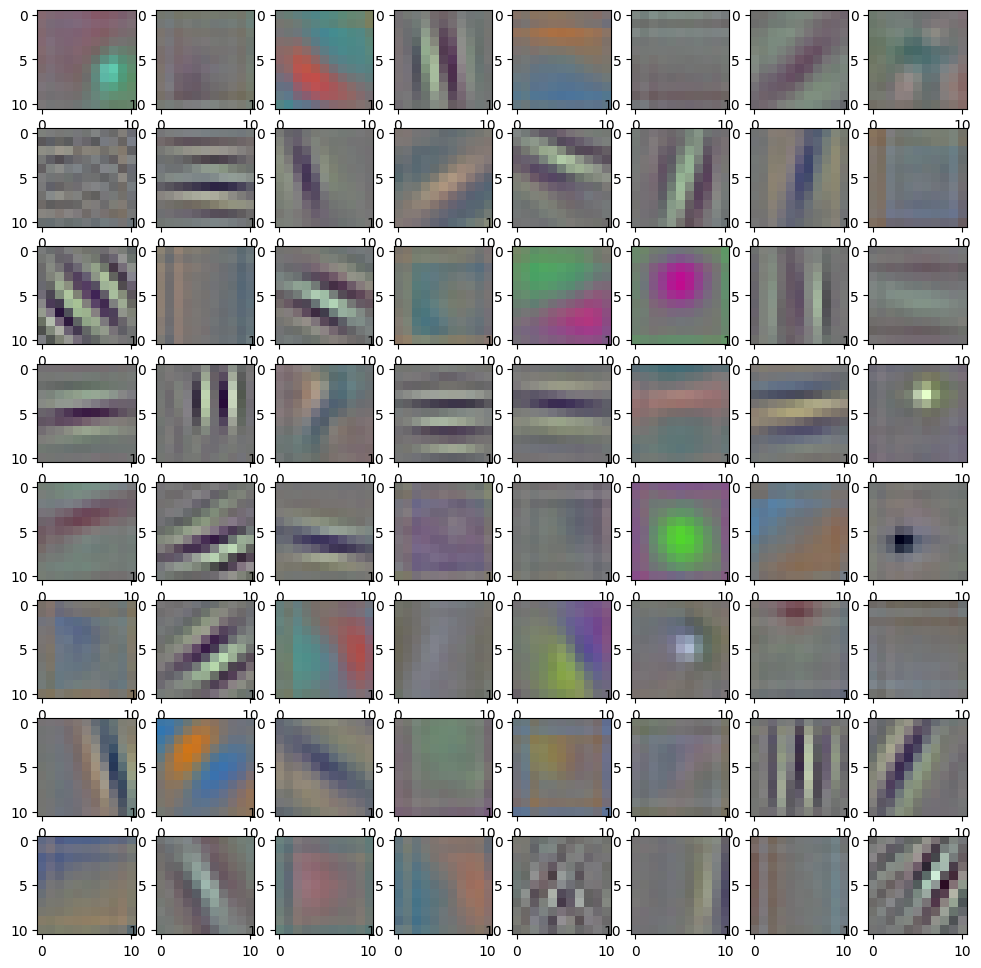

In [4]:
first_layer = alexnet.features[0]  ## access the first layer by indexing on the `features` block of layers
print(first_layer)  ## print the first layer
weights = first_layer.weight.data  ## access the weights of that first layer

# Normalisation for plotting
min_w, max_w =  weights.min(), weights.max()
weights -= min_w
weights /= (max_w-min_w)

fig, axarr = plt.subplots(8, 8, figsize=(12, 12))
axarr = axarr.flatten()

for ax, kernel in zip(axarr, weights.cpu().numpy()):   # plot the three channels at the same
  ax.imshow(np.swapaxes(kernel, 0, 2))                 # time as an RGB image
  # ax.imshow(kernel)                                  # imshow does not like this shape (that's why we swap the axes in the line above)

# for ax, kernel in zip(axarr, weights[:,1,:,:].cpu().numpy()):  # or plot one channel at a time
  # ax.imshow(kernel)                                            # (second dimension of the tensor)

### Access the second layer

We can then follow a similar procedure to acces the second layer of the network.

Notice that in the `Sequential` block called `features`, there's more components than just layers, including `ReLU` and `MaxPool2d`.

Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
torch.Size([192, 64, 5, 5])

filters:  63



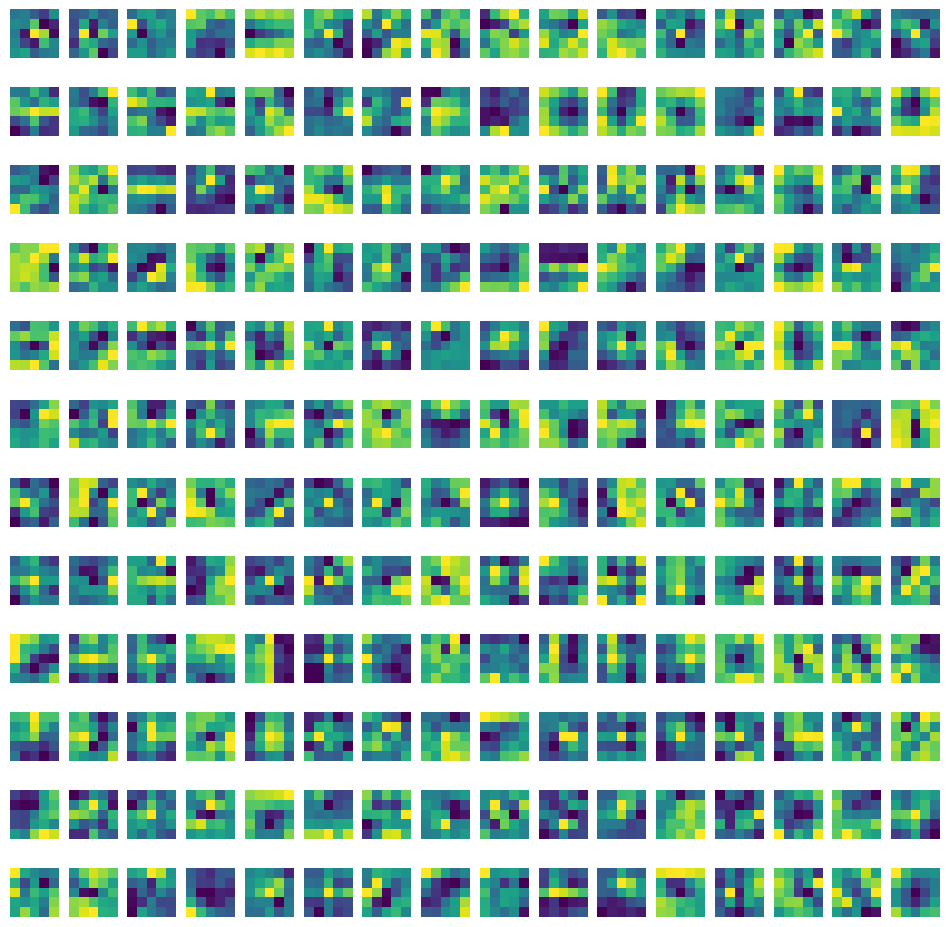

In [5]:
secondconv_layer = alexnet.features[3]  ## access the second layer by indexing on the `features` block of layers
print(secondconv_layer)  ## print the layer
weights = secondconv_layer.weight.data  ## access the weights of that second layer
print(weights.shape)  ## check the shape of the weights

fig, axarr = plt.subplots(12, 16, figsize=(12, 12))
axarr = axarr.flatten()
filter_chan = 63  ## because kernels in the second layer have 64 channels, we are going to plot them by choosing one single channel at a time
print("")
print("filters: ", filter_chan)
print("")
for ax, kernel in zip(axarr, weights[:,filter_chan,:,:].cpu().numpy()):
  ax.imshow(kernel)
  ax.set_axis_off()

### **1.2. Pretrained ResNet**

### Load the model

Let's repeat the process for the ResNet18 pretrained network, `resnet18`.

We can start by loading the pretrained model from `torchvision.models`:

In [6]:
resnet = models.resnet18(pretrained=True).to(device)  ## access ResNet from torchvision.models, load it with pretrained parameters, and send model to the device
print(resnet)  ## print it
print(summary(resnet, input_size=(3,300,300)))  ## print a summary of the model

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 76.7MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Access the first layer

We can similarly access the first layer of the network and its weights.

Notice that, in this case, the first layer is not part of a `Sequential` block.

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
torch.Size([64, 3, 7, 7])
shape of weights:  torch.Size([64, 3, 7, 7])


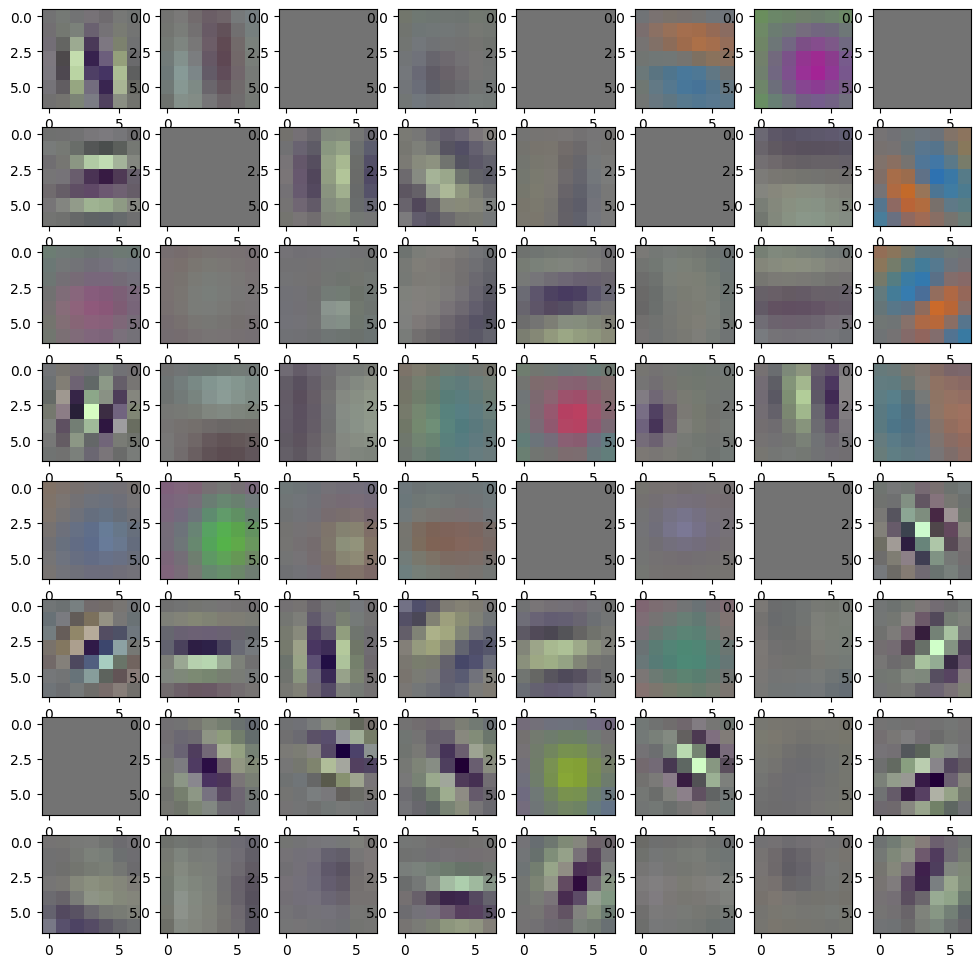

In [7]:
first_layer = resnet.conv1  ## directly access the first layer by name
print(first_layer)  ## print the layer
weights = first_layer.weight.data  ## access the weights of that first layer
print(weights.shape)  ## check the shape

# Normalisation for plotting (values are a bit crazy otherwise, try to comment these lines below and see what happens)
min_w, max_w =  weights.min(), weights.max()
weights -= min_w
weights /= (max_w-min_w)

print('shape of weights: ', weights.shape)

fig, axarr = plt.subplots(8, 8, figsize=(12, 12))
axarr = axarr.flatten()

for ax, kernel in zip(axarr, weights.cpu().numpy()):   # plot the three channels at the same
  ax.imshow(np.swapaxes(kernel, 0, 2))                 # time as an RGB image
  # ax.imshow(kernel)                                  # imshow does not like this shape (that's why we swap the axes in the line above)


# for ax, kernel in zip(axarr, weights[:,1,:,:].cpu().numpy()):  # or plot one channel at a time
  # ax.imshow(kernel)                                            # (second dimension of the tensor)

### **1.3. Pretrained Inception**

### Load the model

Finally, we can also try the loading the `inception_v3` model:

In [8]:
## complete the code
incep =models.inception_v3(pretrained=True).to(device)
print(incep)
summary(incep, input_size=(3,300,300))

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


100%|██████████| 104M/104M [00:00<00:00, 186MB/s] 


Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

### Access an intermediate layer

And access one of the intermediate layers, the third layer of the block `Mixed_5d`.

Notice that here, the layers have a hierarchical structure and can be accessed by name in a nested manner.

Conv2d(48, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
torch.Size([64, 48, 5, 5])


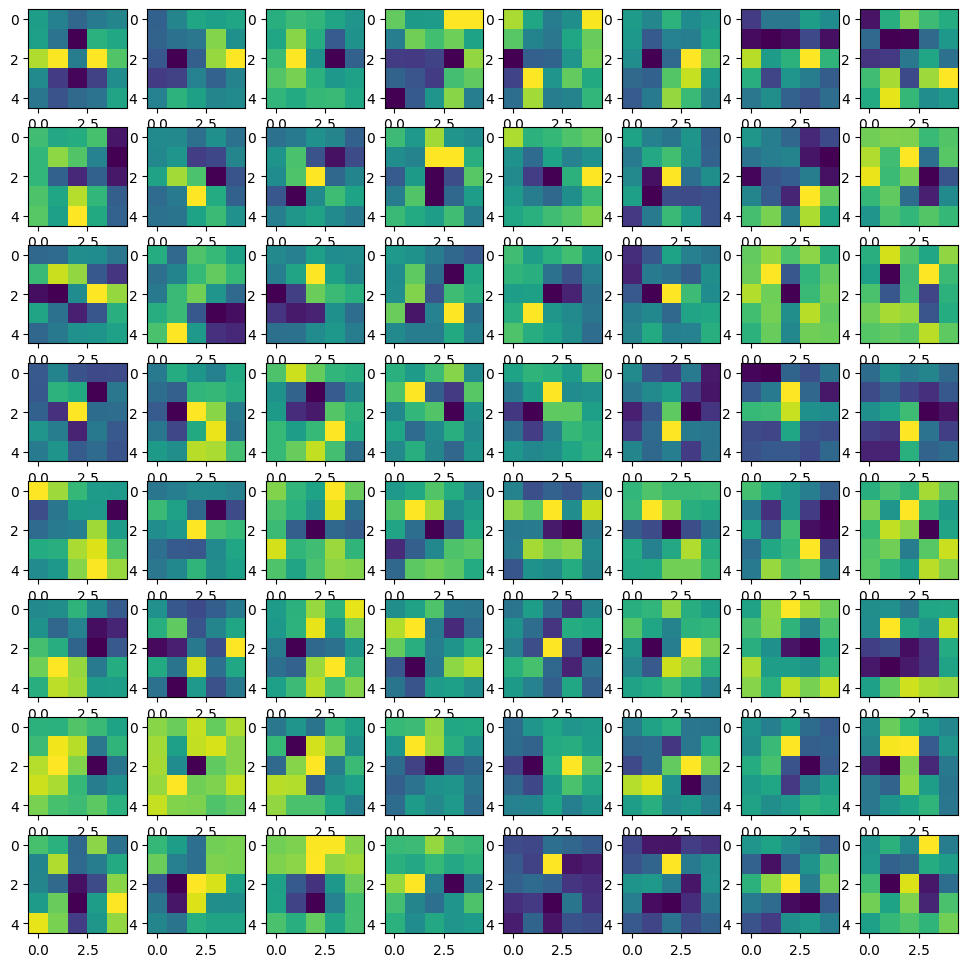

In [9]:
## complete the code
deep_layer = incep.Mixed_5d.branch5x5_2.conv
print(deep_layer)

weights = deep_layer.weight.data
print(weights.shape)

channel = 2

fig, axarr = plt.subplots(8, 8, figsize=(12, 12))
axarr = axarr.flatten()
# for ax, kernel in zip(axarr, weights.cpu().numpy()):
#   ax.imshow(np.swapaxes(kernel, 0, 2))
for ax, kernel in zip(axarr, weights[:,channel,:,:].cpu().numpy()):
  ax.imshow(kernel)

## 2. Transfer learning from ImageNet to Bees and Ants
\[*adapted from [this PyTorch tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)*\]

The basic principle behind transfer learning is to leverage features learned on one dataset and recycle them to perform tasks on another dataset.

Instead of training a network from randomly initialised weights, we start from a network with weights trained in a different domain and fine-tune it to a different source task. By doing this, the weights of the network already have useful properties that can improve optimisation.

To be able to apply transfer learning effectively, the data distribution that a very powerful model was trained on should follow a similar distribution as the other dataset that we are trying to apply transfer learning to.    

For example: _We want to create a new classifier for cats and dogs given only a small set of say 100 training images of each category._

Large neural networks that have been trained on ImageNet or CIFAR have similar categories in their dataset, say horses and maybe cows and many more categories of natural images.  

The rationale is that since we've already learned a set of efficient filters on ImageNet, we can simply use a deep network as a feature extractor and only retrain the final layer —or alternatively fine tune all layers— of a given network to adapt it to our particular task


Transfer learning is a powerful tool because it can:
- prevent poor training from random weights when only small datasets are available.
- reduce training time for tasks that use data with 'similar' distributions

<br>

We will apply transfer learning to a small dataset containing images of bees and ants by transfering learning done by training with the ImageNet dataset.

ImageNet is arguably the most popular dataset for benchmarking classification models. It contains around 14 million annotated natural images spread over 22 thousand categories. Images are of size 3 x 224 x 224, with normalised means and stds of [0.485, 0.456, 0.406] and [0.229, 0.224, 0.225]. In transfer learning is common practice to use the means and standard deviations of the data used for pretraining to normalise the new dataset. Note that the most popular networks (VGG, ResNet, AlexNet, etc.) have been designed to take as input 3 x 224 x 224 images to accomodate for ImageNet.

<br>

<p align = "center"><img src="https://i0.wp.com/syncedreview.com/wp-content/uploads/2020/06/Imagenet.jpg?fit=1400%2C600&ssl=1" width="800"/></p><p align = "center">
<i>ImageNet: >14M images and 20k classes </i>
</p>

<br>

In [10]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/



Let's start by setting some hyperparameters for the next few blocks:

In [11]:
seed = 42
lr = 1e-2
momentum = 0.9
batch_size = 64
test_batch_size = 1000
n_epochs = 30

### **2.1 Loading and Visualising the Data**

[Download](https://download.pytorch.org/tutorial/hymenoptera_data.zip) the dataset into your current directory (you can do it using the code provided below).

In [12]:
set_seed(seed)

True

In [13]:
!wget -nc https://download.pytorch.org/tutorial/hymenoptera_data.zip && unzip -oq hymenoptera_data.zip

--2025-11-28 17:08:37--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 3.167.192.82, 3.167.192.5, 3.167.192.62, ...
Connecting to download.pytorch.org (download.pytorch.org)|3.167.192.82|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M   289MB/s    in 0.2s    

2025-11-28 17:08:37 (289 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]



Use [```torchvision.datasets.ImageFolder```](https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html) to load the training and validation data into a Pytorch ```Dataset```.

Remember to transform the data into a tensor.

In [14]:
from torchvision import datasets, transforms, models

transform = transforms.Compose([
        transforms.ToTensor(),
    ])

train_ds = datasets.ImageFolder("./hymenoptera_data/train", transform=transform)
test_ds = datasets.ImageFolder("./hymenoptera_data/val", transform=transform)

print(train_ds)
print(train_ds.classes)
print(train_ds.class_to_idx)
print(train_ds[0]) # an example of calling  __getitem__, which is what the dataloader does
print(train_ds.samples[0]) # get image path inside samples
print("\n\n")

# Get mean and std
tmp_loader = DataLoader(train_ds, batch_size=1, num_workers=0)
data = next(iter(tmp_loader))
mean = [torch.mean(data[0][0][i].flatten()).item() for i in range(3)]
std = [torch.std(data[0][0][i].flatten()).item() for i in range(3)]
print(mean, std)

Dataset ImageFolder
    Number of datapoints: 244
    Root location: ./hymenoptera_data/train
    StandardTransform
Transform: Compose(
               ToTensor()
           )
['ants', 'bees']
{'ants': 0, 'bees': 1}
(tensor([[[0.3137, 0.3137, 0.3137,  ..., 0.3176, 0.3098, 0.2980],
         [0.3176, 0.3176, 0.3176,  ..., 0.3176, 0.3098, 0.2980],
         [0.3216, 0.3216, 0.3216,  ..., 0.3137, 0.3098, 0.3020],
         ...,
         [0.3412, 0.3412, 0.3373,  ..., 0.1725, 0.3725, 0.3529],
         [0.3412, 0.3412, 0.3373,  ..., 0.3294, 0.3529, 0.3294],
         [0.3412, 0.3412, 0.3373,  ..., 0.3098, 0.3059, 0.3294]],

        [[0.5922, 0.5922, 0.5922,  ..., 0.5961, 0.5882, 0.5765],
         [0.5961, 0.5961, 0.5961,  ..., 0.5961, 0.5882, 0.5765],
         [0.6000, 0.6000, 0.6000,  ..., 0.5922, 0.5882, 0.5804],
         ...,
         [0.6275, 0.6275, 0.6235,  ..., 0.3608, 0.6196, 0.6157],
         [0.6275, 0.6275, 0.6235,  ..., 0.5765, 0.6275, 0.5961],
         [0.6275, 0.6275, 0.6235,  ...,

 Investigate and visualize a few examples of the dataset, by plotting them, looking at their shape, etc.

In [15]:
def show_batch(dataset, nr=4, nc=4):
  fig, axarr = plt.subplots(nr, nc, figsize=(10, 10))
  for i in range(nr):
      for j in range(nc):
          idx = random.randint(0, len(dataset))
          sample, target = dataset[idx]
          if sample.min() < 0.:
            sample = (sample - sample.min())/(sample.max() - sample.min())
          try:
            axarr[i][j].imshow(sample) # if PIL
          except:
            axarr[i][j].imshow(sample.permute(1,2,0)) # if tensor of shape CHW
          target_name = dataset.classes[target]
          axarr[i][j].set_title("%s (%i)"%(target_name, target))

  fig.tight_layout(pad=1.5)
  plt.show()

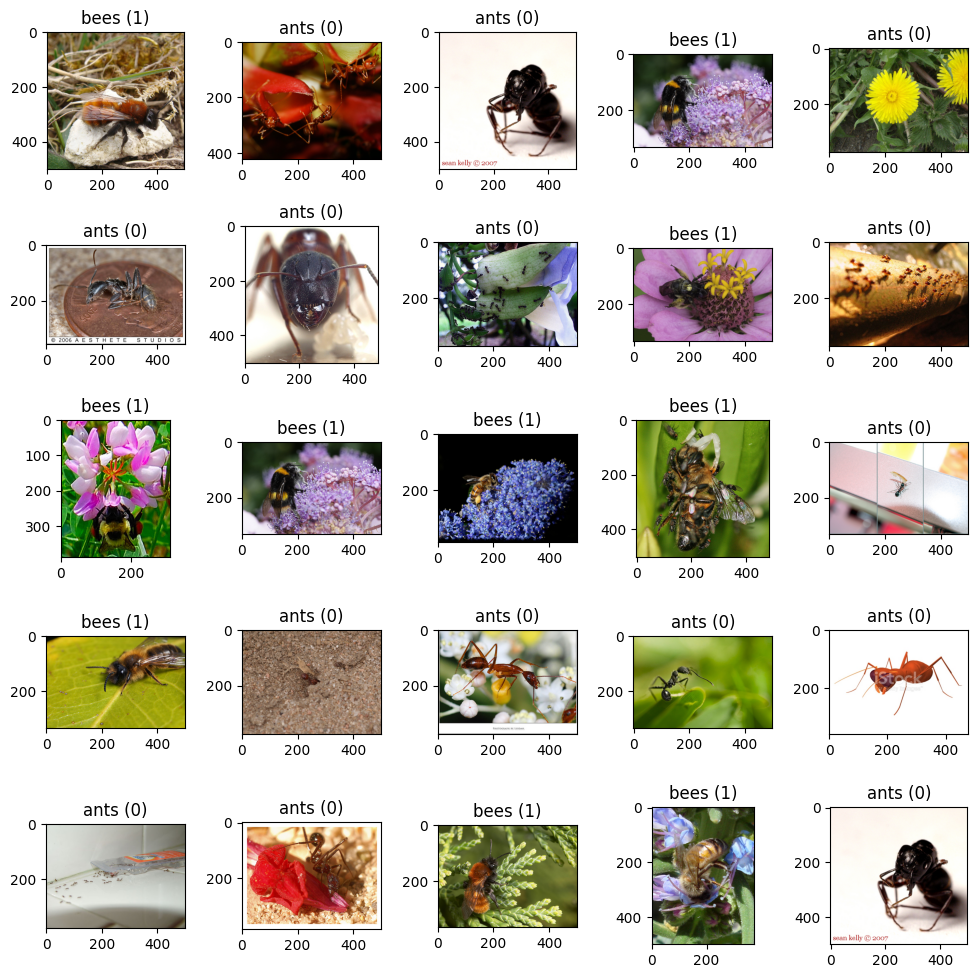

In [16]:
show_batch(train_ds, 5, 5)

Now, given what we know about ImageNet and the ResNet architecture, what other pre-processing is required?

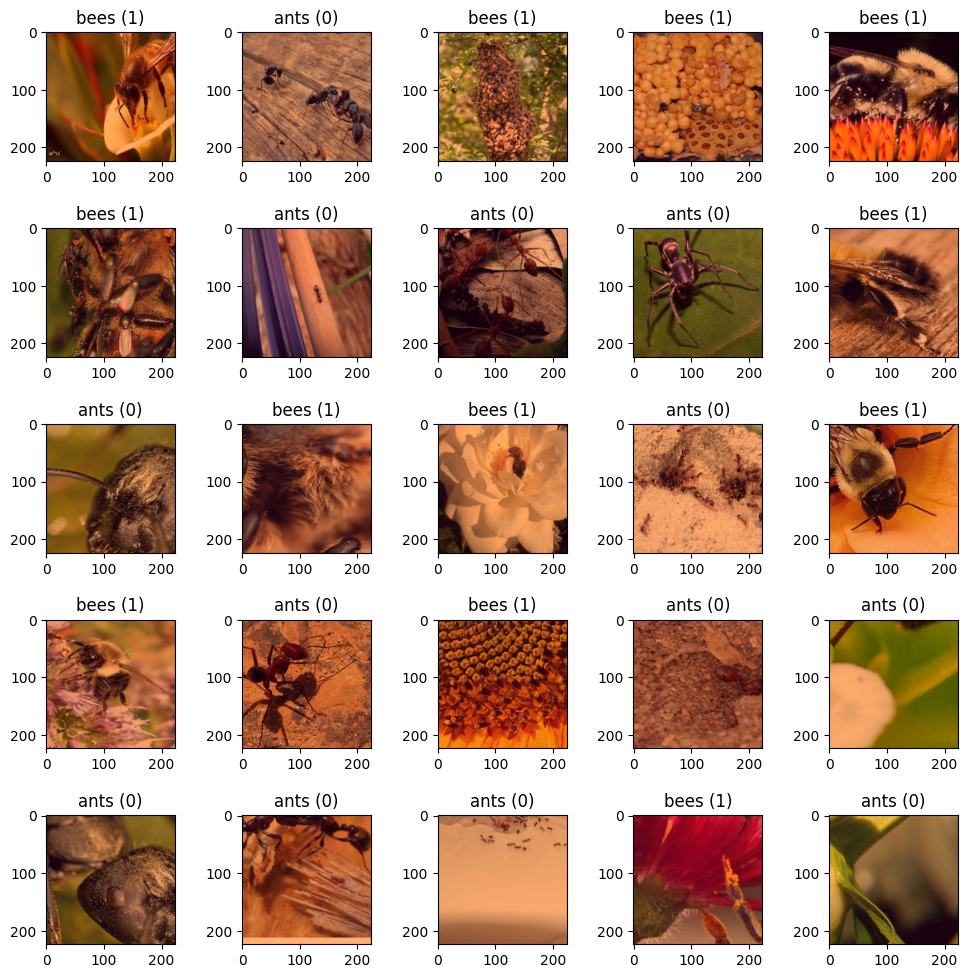

In [17]:
# Finally add normalisation to transforms
train_transform = transforms.Compose([
        transforms.RandomResizedCrop(224),  ## add a transform that does a random crop with the right size here
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)  ## normalise the dataset
    ])
test_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)  ## normalise the dataset
    ])

train_ds = datasets.ImageFolder("./hymenoptera_data/train", transform=train_transform)  ## create a training ImageFolder
test_ds =  datasets.ImageFolder("./hymenoptera_data/val", transform=train_transform)  ## create a testing ImageFolder

show_batch(train_ds, 5, 5)

Finally, let's create `DataLoader`s for your transformed dataset.

In [18]:
# Create dataloader
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=0)

### **2.2. Adapting training, validation and evaluation functions**

Start by adapting the training, validation and evaluation functions to the appropriate size of inputs that the network expects.

Before you start writing the code, consider what this size should be given what you know about ResNet.

In [19]:
def train(model, optimizer, criterion, data_loader):
    model.train()
    train_loss, train_accuracy = 0, 0
    for X, y in data_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        a2 = model(X.view(-1, 3, 224, 224))
        loss = criterion(a2, y)
        loss.backward()
        train_loss += loss*X.size(0)
        y_pred = F.log_softmax(a2, dim=1).max(1)[1]
        train_accuracy += accuracy_score(y.cpu().numpy(), y_pred.detach().cpu().numpy())*X.size(0)
        optimizer.step()

    return train_loss/len(data_loader.dataset), train_accuracy/len(data_loader.dataset)

def validate(model, criterion, data_loader):
    model.eval()
    validation_loss, validation_accuracy = 0., 0.
    for X, y in data_loader:
        with torch.no_grad():
            X, y = X.to(device), y.to(device)
            a2 = model(X.view(-1, 3, 224, 224))
            loss = criterion(a2, y)
            validation_loss += loss*X.size(0)
            y_pred = F.log_softmax(a2, dim=1).max(1)[1]
            validation_accuracy += accuracy_score(y.cpu().numpy(), y_pred.cpu().numpy())*X.size(0)

    return validation_loss/len(data_loader.dataset), validation_accuracy/len(data_loader.dataset)

def evaluate(model, data_loader):
    model.eval()
    ys, y_preds = [], []
    for X, y in data_loader:
        with torch.no_grad():
            X, y = X.to(device), y.to(device)
            a2 = model(X.view(-1, 3, 224, 224))
            y_pred = F.log_softmax(a2, dim=1).max(1)[1]
            ys.append(y.cpu().numpy())
            y_preds.append(y_pred.cpu().numpy())

    return np.concatenate(y_preds, 0),  np.concatenate(ys, 0)

### **2.3. Instantiate untrained Resnet18**


Instantiate an untrained ResNet18 from [```torchvision.models```](https://pytorch.org/vision/stable/models.html). Then, reinitialise the last connected layer ```model.fc``` with a new fully connected layer with appropriate input and output sizes.

Why is it important to replace the last layer of the network?

In [20]:
set_seed(seed)

model = models.resnet18().to(device)
print(model)
model.fc = nn.Linear(model.fc.in_features, 2).to(device)  ## this line is provided, but what does it do?

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

We can now train the model using our modified train and validation loops.

What conclusions can you extract from the training results?

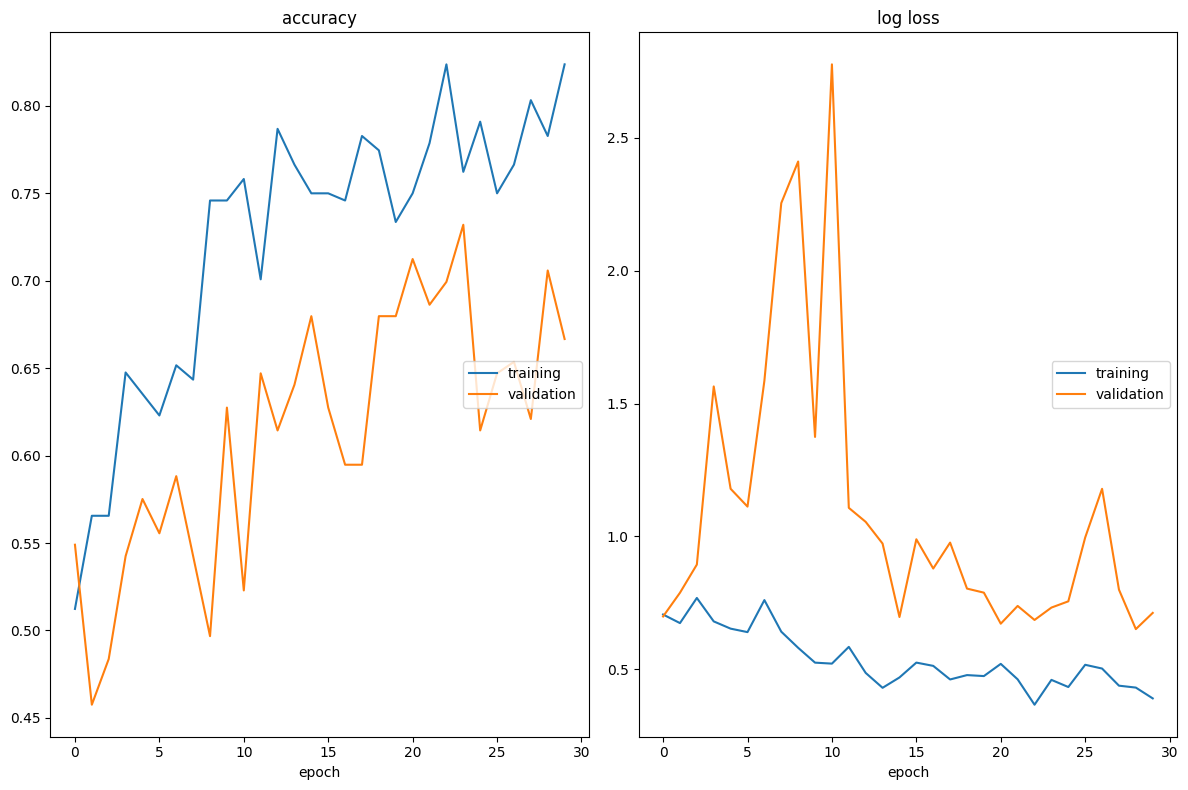

accuracy
	training         	 (min:    0.512, max:    0.824, cur:    0.824)
	validation       	 (min:    0.458, max:    0.732, cur:    0.667)
log loss
	training         	 (min:    0.366, max:    0.768, cur:    0.390)
	validation       	 (min:    0.651, max:    2.777, cur:    0.712)
Avg. Test Loss: 0.773  Avg. Test Accuracy: 0.647



In [21]:
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum) ## define your optimiser (SGD with momentum)
criterion = nn.CrossEntropyLoss()  ## define your loss

liveloss = PlotLosses()
for epoch in range(n_epochs):
    logs = {}
    train_loss, train_accuracy = train(model, optimizer, criterion, train_loader)

    logs['' + 'log loss'] = train_loss.item()
    logs['' + 'accuracy'] = train_accuracy

    validation_loss, validation_accuracy = validate(model, criterion, test_loader)
    logs['val_' + 'log loss'] = validation_loss.item()
    logs['val_' + 'accuracy'] = validation_accuracy

    liveloss.update(logs)
    liveloss.draw()

test_loss, test_accuracy = validate(model, criterion, test_loader)
print("Avg. Test Loss: %1.3f" % test_loss.item(), " Avg. Test Accuracy: %1.3f" % test_accuracy)
print("")

model_save_name = 'resnet18_bees_and_ants_classifier_full_training_set_baseline.pt'
path = F"/content/gdrive/MyDrive/models/{model_save_name}"
torch.save(model.state_dict(), path)

Our model is not doing too well. The lack of data is taking a toll on our training and giving a large generalisation error.

### **2.3. Finetuning a pre-trained Resnet**

Now, let's instantiate the pre-trained ReseNet18 by passing the argument ``pretrained=True``.

In [22]:
model = models.resnet18(pretrained=True).to(device)
model.fc = nn.Linear(model.fc.in_features, 2).to(device)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


And let's perform fine-tuning using a smaller learning rate of ```1e-3```.

What do you notice now with respect to the previous training?

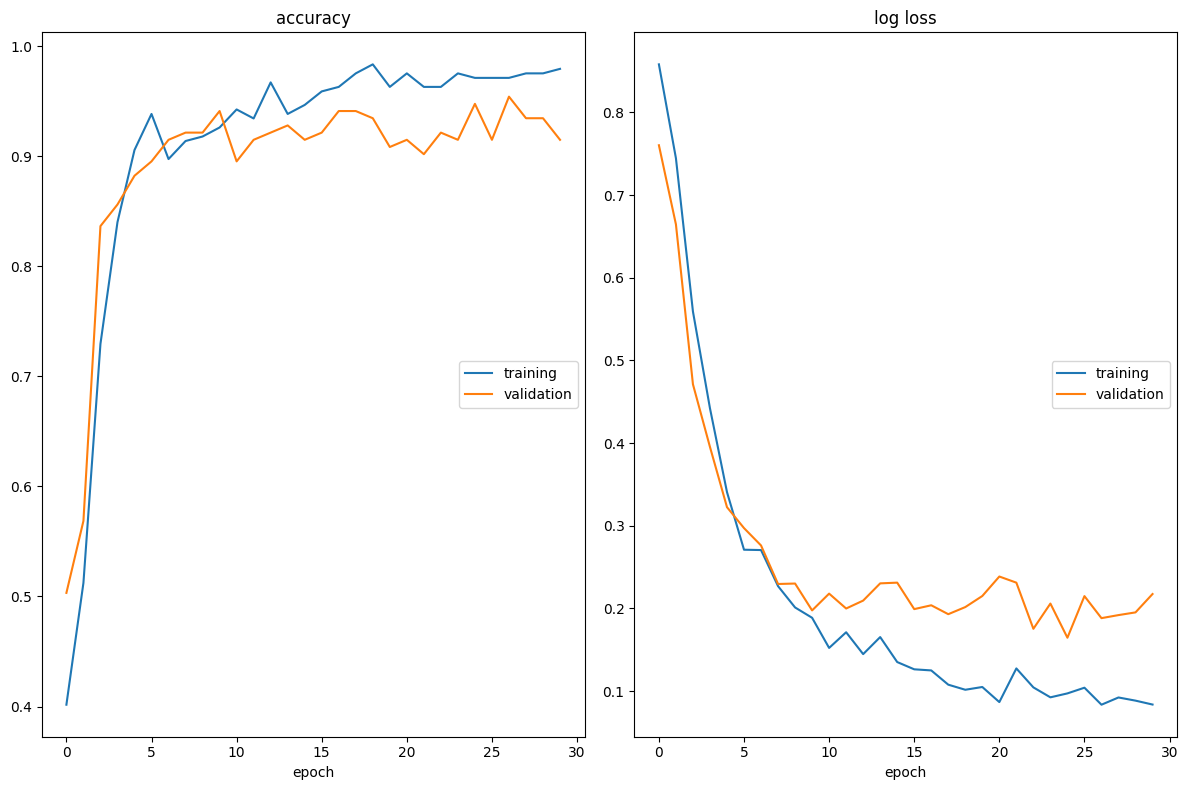

accuracy
	training         	 (min:    0.402, max:    0.984, cur:    0.980)
	validation       	 (min:    0.503, max:    0.954, cur:    0.915)
log loss
	training         	 (min:    0.084, max:    0.858, cur:    0.084)
	validation       	 (min:    0.165, max:    0.760, cur:    0.217)
Avg. Test Loss: 0.198  Avg. Test Accuracy: 0.928



In [23]:
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=momentum) ## define your optimiser (SGD with momentum) and make sure to adapt the learning rate to 'fine-tune' the network
criterion = nn.CrossEntropyLoss()  ## define your loss

liveloss = PlotLosses()
for epoch in range(n_epochs):
    logs = {}
    train_loss, train_accuracy = train(model, optimizer, criterion, train_loader)

    logs['' + 'log loss'] = train_loss.item()
    logs['' + 'accuracy'] = train_accuracy

    validation_loss, validation_accuracy = validate(model, criterion, test_loader)
    logs['val_' + 'log loss'] = validation_loss.item()
    logs['val_' + 'accuracy'] = validation_accuracy

    liveloss.update(logs)
    liveloss.draw()

test_loss, test_accuracy = validate(model, criterion, test_loader)
print("Avg. Test Loss: %1.3f" % test_loss.item(), " Avg. Test Accuracy: %1.3f" % test_accuracy)
print("")

model_save_name = 'resnet18_bees_and_ants_classifier_full_training_set_imagenet_finetune.pt'
path = F"/content/gdrive/MyDrive/models/{model_save_name}"
torch.save(model.state_dict(), path)

This is much better now.

We could also try to change how we normalise the dataset by using the same mean and standard deviation that the original training used for ImageNet:

In [27]:
train_transform = transforms.Compose([
        transforms.RandomResizedCrop(224),  ## add a transform that does a random crop with the right size here
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),  ## why are we using these numbers here?
    ])
test_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),  ## why are we using these numbers here?
    ])

train_ds = datasets.ImageFolder("./hymenoptera_data/train", transform=train_transform)
test_ds = datasets.ImageFolder("./hymenoptera_data/val", transform=test_transform)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=0)

Let's see how this impacts the training results.

What conclusions can you draw from this?

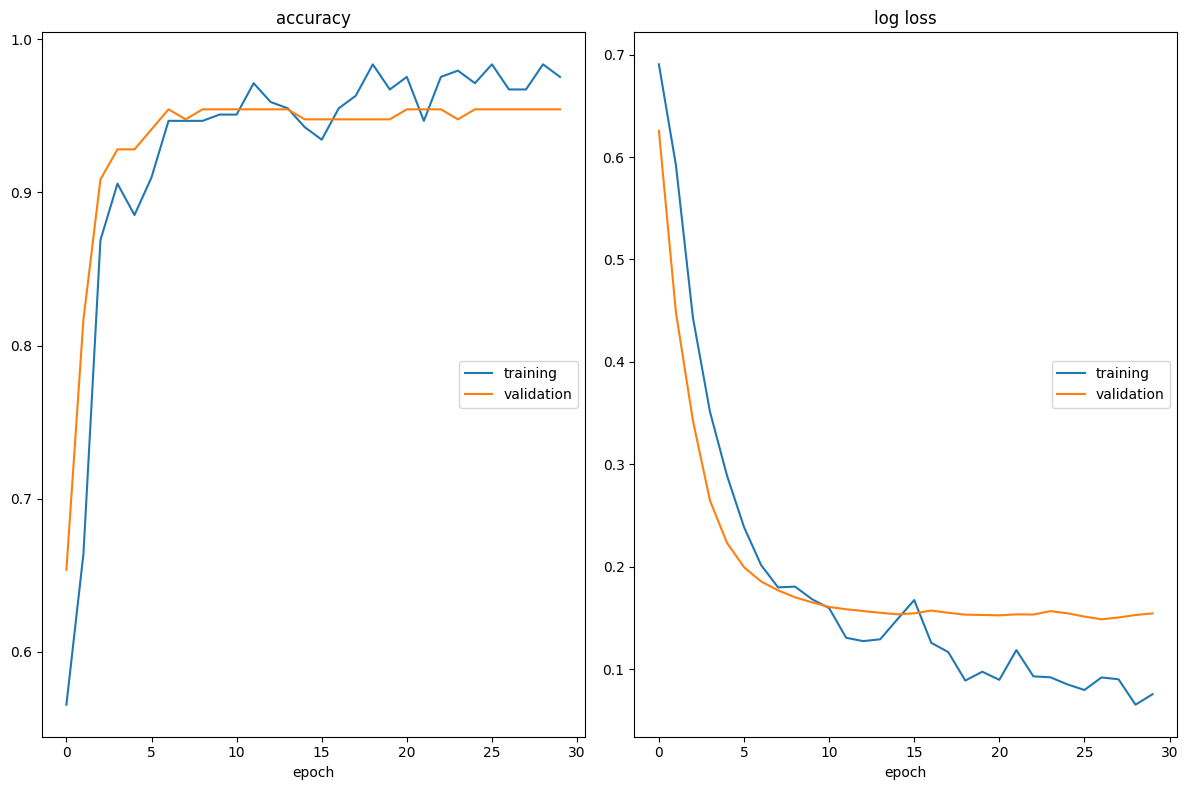

accuracy
	training         	 (min:    0.566, max:    0.984, cur:    0.975)
	validation       	 (min:    0.654, max:    0.954, cur:    0.954)
log loss
	training         	 (min:    0.065, max:    0.690, cur:    0.075)
	validation       	 (min:    0.149, max:    0.626, cur:    0.154)
Avg. Test Loss: 0.154  Avg. Test Accuracy: 0.954



In [28]:
model = models.resnet18(pretrained=True).to(device)
model.fc = nn.Linear(model.fc.in_features, 2).to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=momentum)  ## define your optimiser (SGC with momentum) and make sure to adapt the learning rate to 'fine-tune' the network
criterion = nn.CrossEntropyLoss()  ## define your loss

liveloss = PlotLosses()
for epoch in range(n_epochs):
    logs = {}
    train_loss, train_accuracy = train(model, optimizer, criterion, train_loader)

    logs['' + 'log loss'] = train_loss.item()
    logs['' + 'accuracy'] = train_accuracy

    validation_loss, validation_accuracy = validate(model, criterion, test_loader)
    logs['val_' + 'log loss'] = validation_loss.item()
    logs['val_' + 'accuracy'] = validation_accuracy

    liveloss.update(logs)
    liveloss.draw()

test_loss, test_accuracy = validate(model, criterion, test_loader)
print("Avg. Test Loss: %1.3f" % test_loss.item(), " Avg. Test Accuracy: %1.3f" % test_accuracy)
print("")

model_save_name = 'resnet18_bees_and_ants_classifier_full_training_set_imagenet_finetune.pt'
path = F"/content/gdrive/MyDrive/models/{model_save_name}"
torch.save(model.state_dict(), path)

### **2.4. Pre-trained Resnet with retrained last layer**

Use the following provided functions:

In [29]:
def set_parameter_requires_grad(model, requires_grad=False):
    """https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html"""
    for param in model.parameters():
        param.requires_grad = requires_grad
    return None

def get_params_to_update(model):
    """ Returns list of model parameters that have required_grad=True"""
    params_to_update = []
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
    return params_to_update

Now, repeat the step above, but now freezing optimisation for all layers except the final classifying layer (instead of retraining the whole network with a smaller learning rate).

In [30]:
model = models.resnet18(pretrained=True).to(device)     ## get an instance of a pre-trained resnet-18
set_parameter_requires_grad(model, requires_grad=False)      ## use the provdied set_parameter_requires_grad to disable training
model.fc = nn.Linear(model.fc.in_features, 2).to(device)  ## add a last layer of the network that you need. Newly initialised layers automatically have requires_grad=True

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


We can see the impact on the training results.

Which of the approaches so far would be most appropriate for this dataset?

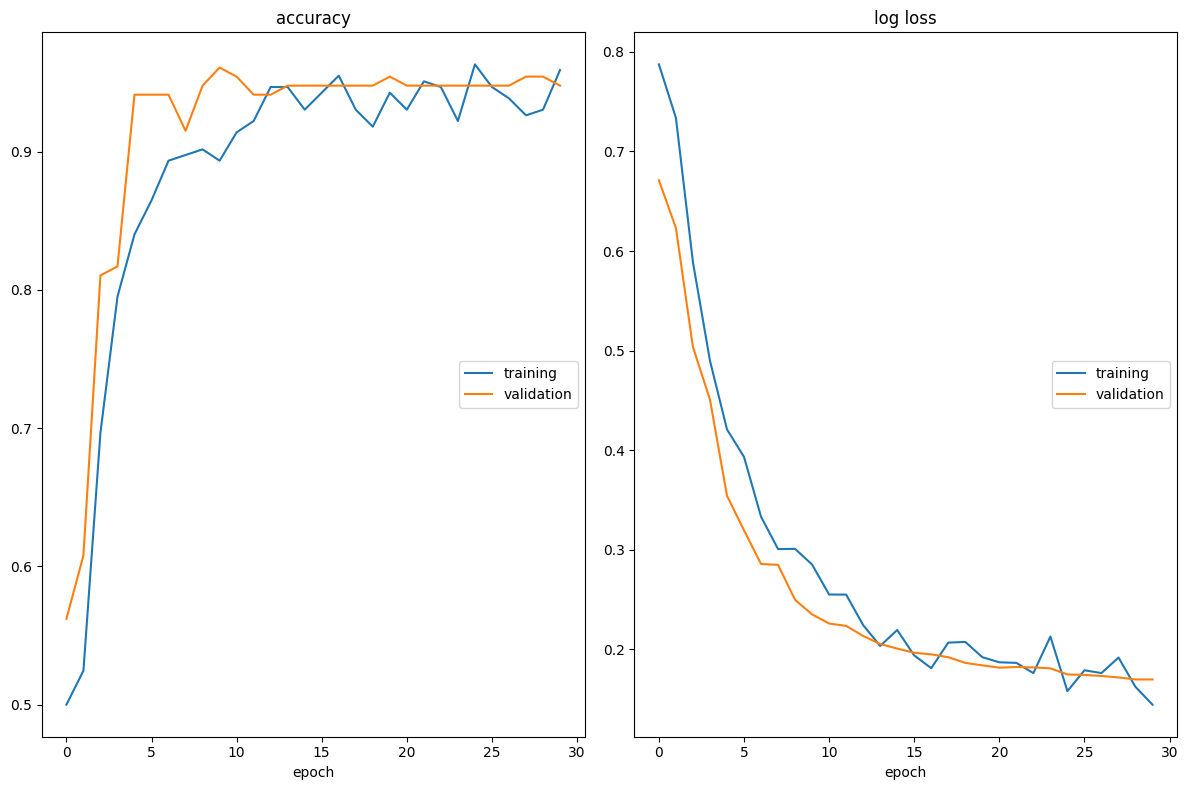

accuracy
	training         	 (min:    0.500, max:    0.963, cur:    0.959)
	validation       	 (min:    0.562, max:    0.961, cur:    0.948)
log loss
	training         	 (min:    0.144, max:    0.788, cur:    0.144)
	validation       	 (min:    0.170, max:    0.671, cur:    0.170)
Avg. Test Loss: 0.170  Avg. Test Accuracy: 0.948



In [31]:
optimizer = torch.optim.SGD(get_params_to_update(model), lr=1e-3, momentum=momentum)  ## define optimiser and use the provided get_params_to_update function to tell it to only update what you want
criterion = nn.CrossEntropyLoss()

liveloss = PlotLosses()
for epoch in range(n_epochs):
    logs = {}
    train_loss, train_accuracy = train(model, optimizer, criterion, train_loader)

    logs['' + 'log loss'] = train_loss.item()
    logs['' + 'accuracy'] = train_accuracy

    validation_loss, validation_accuracy = validate(model, criterion, test_loader)
    logs['val_' + 'log loss'] = validation_loss.item()
    logs['val_' + 'accuracy'] = validation_accuracy

    liveloss.update(logs)
    liveloss.draw()

test_loss, test_accuracy = validate(model, criterion, test_loader)
print("Avg. Test Loss: %1.3f" % test_loss.item(), " Avg. Test Accuracy: %1.3f" % test_accuracy)
print("")

model_save_name = 'resnet18_bees_and_ants_classifier_full_training_set_imagenet_feature_extract.pt'
path = F"/content/gdrive/MyDrive/models/{model_save_name}"
torch.save(model.state_dict(), path)

If feature extraction can provide sufficiently good accuracy, we can significantly cut in training time, particularly when the network is very deep and input images are large.

Fine tuning our model parts from the idea that the model's initial weights and biases are already quite close to the global minimum in the solution space, and that all we are doing is converging to the new minimum defined by our problem (which is close to the one for the pretrained network).

Feature extraction makes use of the exact features that are used to classified another dataset, only really tuning the final classifying layer.

<img src="https://pbs.twimg.com/media/Ev-f6AaU8AgMeRd.jpg" alt="drawing" width="600"/>

### **2.5. What if pretrained on MNIST instead?**

Finally, let's train a ResNet on MNIST from scratch and use those weights to repeat step 5 on the bees and ants dataset.

Once you have done this, think whether this suitable for this problem.

Let's start by preparing the MNIST dataset to work with ResNet:

In [32]:
train_transform = transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
        transforms.Lambda(lambda x: x.expand(3, 224, 224)),   # expand to 3 channels
    ])
test_transform = transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
        transforms.Lambda(lambda x: x.expand(3, 224, 224)),   # expand to 3 channels
    ])

mnist_train = MNIST("./", download=True, train=True, transform=train_transform)
mnist_test = MNIST("./", download=True, train=False, transform=test_transform)

mnist_train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=0)
mnist_test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=False, num_workers=0)

100%|██████████| 9.91M/9.91M [00:00<00:00, 19.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 497kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.73MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 17.3MB/s]


We can then instantiate the ResNet model again. Remember to replace the last layer of the network.

In [33]:
model = models.resnet18().to(device)
model.fc = nn.Linear(model.fc.in_features, 10).to(device)  ## add the last layer you need here

optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
criterion = nn.CrossEntropyLoss()

And let's train the resulting model:

In [ ]:
liveloss = PlotLosses()
for epoch in range(n_epochs):
    logs = {}
    train_loss, train_accuracy = train(model, optimizer, criterion, mnist_train_loader)

    logs['' + 'log loss'] = train_loss.item()
    logs['' + 'accuracy'] = train_accuracy

    validation_loss, validation_accuracy = validate(model, criterion, mnist_test_loader)
    logs['val_' + 'log loss'] = validation_loss.item()
    logs['val_' + 'accuracy'] = validation_accuracy

    liveloss.update(logs)
    liveloss.draw()

model_save_name = 'resnet18_mnist_classifier_full_training_set_baseline_.pt'
path = F"/content/gdrive/MyDrive/models/{model_save_name}"
torch.save(model.state_dict(), path)


test_loss, test_accuracy = validate(model, criterion, test_loader)
print("Avg. Test Loss: %1.3f" % test_loss.item(), " Avg. Test Accuracy: %1.3f" % test_accuracy)
print("")

### **2.6. Transfer learning on the ResNet pretrained on MNIST**

Now that we have trained the ResNet model on MNIST, we are going to do transfer learning to the Bees and Ants dataset as we have done before.

Let's load the pre-trained ResNet and then replace the last layer.


In [ ]:
model = models.resnet18().to(device)
model.fc = nn.Linear(model.fc.in_features, 10).to(device)  ## add the last layer you need here

path = F"/content/gdrive/My Drive/models/{model_save_name}"
model.load_state_dict(torch.load(path))

model.fc = nn.Linear(model.fc.in_features, 2).to(device)  ## add the last layer you need here

Train the model as we have done before.

How does the network perform?

In [ ]:
optimizer = torch.optim.SGD(model.fc.parameters(), lr=1e-3, momentum=momentum)
criterion = nn.CrossEntropyLoss()

liveloss = PlotLosses()
for epoch in range(n_epochs):
    logs = {}
    train_loss, train_accuracy = train(model, optimizer, criterion, train_loader)

    logs['' + 'log loss'] = train_loss.item()
    logs['' + 'accuracy'] = train_accuracy
    liveloss.update(logs)
    liveloss.draw()
    logs['val_' + 'log loss'] = 0.
    logs['val_' + 'accuracy'] = 0.

model_save_name = 'resnet18_bees_and_antes_classifier_full_training_set_mnist_transfer.pt'
path = F"/content/gdrive/MyDrive/models/{model_save_name}"
torch.save(model.state_dict(), path)


test_loss, test_accuracy = validate(model, criterion, test_loader)
print("Avg. Test Loss: %1.3f" % test_loss.item(), " Avg. Test Accuracy: %1.3f" % test_accuracy)
print("")

<br>
<br>
<br>
<br>

---
---

<br>

## **Clarifying issues with loss averaging:**

In [ ]:
def train(model, optimizer, criterion, data_loader):
    model.train()
    train_loss, train_accuracy = 0, 0
    for X, y in data_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        a2 = model(X.view(-1, 3, 224, 224))
        loss = criterion(a2, y)
        loss.backward()
        train_loss += loss*X.size(0) ## this undoes normalisation
        y_pred = F.log_softmax(a2, dim=1).max(1)[1]
        train_accuracy += accuracy_score(y.cpu().numpy(), y_pred.detach().cpu().numpy())*X.size(0)
        optimizer.step()

    return train_loss/len(data_loader.dataset), train_accuracy/len(data_loader.dataset)

The cross entropy loss provided by PyTorch has a normalisation added to it in [`CrossEntropyLoss`](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html). This line:

`train_loss += loss*X.size(0)`

undoes the normalisation done by `torch.nn.CrossEntropyLoss` and adds the value to the accumulated losses over minibatches.

Then, once we have gone over all the data (that is, over all the minibatches), we will have completed one epoch, and we want to know the value of the normalised loss. To get it, we divide it by the total number of samples in my data:

`return train_loss/len(data_loader.dataset), train_accuracy/len(data_loader.dataset)`

A similar business is going on with the accuracy. In this case we use scikit-learn's [`accuracy_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html). Then, we do:

`train_accuracy += accuracy_score(y.cpu().numpy(), y_pred.detach().cpu().numpy())*X.size(0)`

and then we divide the accuracy by the total length of the data.

<br>
<br>

Finally, this line before the data_loader is iterated:

`train_loss, train_accuracy = 0, 0`

resets the value of the loss value at every epoch.


## Alternative implementations:

Simply modify the default behaviour of the loss and the accuracy calculations:

`torch.nn.CrossEntropyLoss(weight=None, size_average=None, ignore_index=- 100, reduce=None, `**`reduction='mean'`**`, label_smoothing=0.0)`

change default to **`reduction='sum'`** when you define the loss.

<br>

And for the accuracy, just change the line:

`train_accuracy += accuracy_score(y.cpu().numpy(), y_pred.detach().cpu().numpy(),`**`normalize=False`**`)`

to accumulate the sum of the loss, so it is naturally scaled to the batch size.


<br>

---

<br>